In [1]:
import collections
import pandas as pd
import csv
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.stats import zscore
import seaborn as sns
import time

In [2]:
#Formatting string for time.
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Read in the data of trended US Youtube videos

In [3]:
data = pd.read_csv('USvideos.csv')
data.columns = [ 'video_id',
'trending_date',
'title',
'channel_title',
'category_id',
'publish_time',
'tags',
'views',
'likes',
'dislikes',
'comment_count',
'thumbnail_link',
'comments_disabled',
'ratings_disabled',
'video_error_or_removed',
'description' ]
data.description = data.description.astype(str)

In [4]:
data.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [5]:
import json
id_to_category = {}

type_str_list = ['category_id']
for column in type_str_list:
    data[column] = data[column].astype(str)
    
with open('US_category_id.json', 'r') as f:
    data2 = json.load(f)
    for category in data2['items']:
        id_to_category[category['id']] = category['snippet']['title']
id_to_category

data.insert(4, 'category', data['category_id'].map(id_to_category))
data[['category_id', 'category']].head()

,category_id,category
0,22,People & Blogs
1,24,Entertainment
2,23,Comedy
3,24,Entertainment
4,24,Entertainment


# Encoding data
Encoding the categorical classification of each video as the y_data

In [6]:
y_data = data['category']
y_data = pd.get_dummies(y_data, columns=['category'], drop_first = True)
y_data.head()

,Comedy,Education,Entertainment,Film & Animation,Gaming,Howto & Style,Music,News & Politics,Nonprofits & Activism,People & Blogs,Pets & Animals,Science & Technology,Shows,Sports,Travel & Events
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


# Graph visualizing the category distribution of videos in the United States

Text(0.5, 1.0, 'Categories of trend videos in United States')

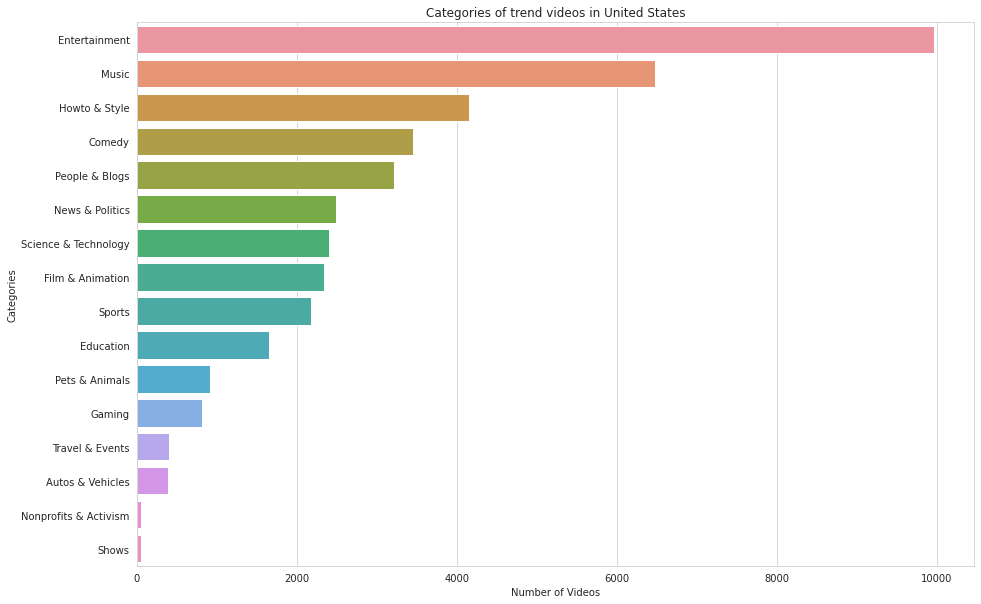

In [7]:
cat_df_gb = data['category'].value_counts().reset_index()
plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
ax = sns.barplot(y=cat_df_gb['index'],x=cat_df_gb['category'], data=cat_df_gb,orient='h')
plt.xlabel("Number of Videos")## From United States users : 
plt.ylabel("Categories")
plt.title("Categories of trend videos in United States")

# Normalizing the tags, titles, and description

In [8]:
import re
import string

def normalize_text(text):
    i = 0
    try:
        for index in text:
            if text[i] == "nan":
                text[i] = ""
            else:
                text[i] = text[i].replace("\\n", " ")
                text[i] = text[i].lower()
                text[i] = re.sub(r'\d+', '', text[i])
                text[i] = text[i].replace("|", " ")
                text[i] = re.sub(r'[^\w\s]','', text[i])
                text[i] = re.sub(r"(https)(\w+)\b", '', text[i])
                text[i] = re.sub(r"(http)(\w+)\b", '', text[i])
                text[i] = re.sub(r"(www.)(\w+)\b", '', text[i])
            i+=1
    except Exception as error:
        # verbosely print record that caused the exception
        print("An unexpected exception occured while parsing the following record:")
        print(text[i+1])
        raise error
    
    print(text[1], "\n")
    return text

Normalize the text data by calling the function normalize_text as defined above

In [9]:
#Normalize the tags
print("tags: ")
tags = normalize_text(data['tags'].values)

#Normalize the titles
print("title: ")
title = normalize_text(data['title'].values)

#Normalize the description
print("description: ")
description = normalize_text(data['description'].values)

tags: 
last week tonight trump presidency last week tonight donald trump john oliver trump donald trump 

title: 
the trump presidency last week tonight with john oliver hbo 

description: 
one year after the presidential election john oliver discusses what weve learned so far and enlists our catheter cowboy to teach donald trump what he hasnt  connect with last week tonight online  subscribe to the last week tonight youtube channel for more almost news as it almost happens   find last week tonight on facebook like your mom would   follow us on twitter for news about jokes and jokes about news   visit our official site for all that other stuff at once  



## Taking encoded word data and combining them into a set

In [10]:
text = {'description': description, 'title': title, 'tags': tags}
print("text['description']: ", text['description'])

text['description']:  ['shantells channel   candice    filmed this video in k on this   with this lens   big drone   other gear    sony camera  old camera  main lens  big sony camera  big canon camera  bendy tripod thing  you need this for the bendy tripod  wide lens  more expensive wide lens  small camera  microphone  other microphone  old drone cheaper but still great  follow me on  on  on   amazing intro song by   ad disclosure  this is not an ad  not selling or promoting anything  but samsung did produce the shantell video as a galaxy project which is an initiative that enables creators like shantell and me to make projects we might otherwise not have the opportunity to make  hope thats clear  if not ask in the comments and ill answer any specifics'
 'one year after the presidential election john oliver discusses what weve learned so far and enlists our catheter cowboy to teach donald trump what he hasnt  connect with last week tonight online  subscribe to the last week tonight you

In [11]:
description

array(['shantells channel   candice    filmed this video in k on this   with this lens   big drone   other gear    sony camera  old camera  main lens  big sony camera  big canon camera  bendy tripod thing  you need this for the bendy tripod  wide lens  more expensive wide lens  small camera  microphone  other microphone  old drone cheaper but still great  follow me on  on  on   amazing intro song by   ad disclosure  this is not an ad  not selling or promoting anything  but samsung did produce the shantell video as a galaxy project which is an initiative that enables creators like shantell and me to make projects we might otherwise not have the opportunity to make  hope thats clear  if not ask in the comments and ill answer any specifics',
       'one year after the presidential election john oliver discusses what weve learned so far and enlists our catheter cowboy to teach donald trump what he hasnt  connect with last week tonight online  subscribe to the last week tonight youtube chan

# Using TfidfVectorizer to calculate the Tfidf of the set into the x_data

The TF-IDF vectorizer with a higher minimum and a lower max

In [12]:
import sklearn.feature_extraction.text as sk_text

vectorizer = sk_text.TfidfVectorizer(stop_words='english',
                             max_features = 50,
                             min_df=5, 
                             #max_df=5
                             )

#min_df: ignore terms that have a document frequency < min_df.
#max_df: ignore terms that have a document frequency > max_df

matrix = vectorizer.fit_transform(text['description'], text['tags'])

x_data = matrix.toarray()     #  convert it to numpy array

print(x_data)
print(x_data.shape)
print(vectorizer.get_feature_names())
print(len(vectorizer.get_feature_names()))


[[0.         0.         0.30754216 ... 0.         0.         0.        ]
 [0.         0.         0.20074925 ... 0.         0.         0.21058858]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.49594483 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(40949, 50)
['best', 'box', 'channel', 'check', 'click', 'code', 'day', 'dont', 'facebook', 'follow', 'free', 'google', 'im', 'instagram', 'jimmy', 'just', 'know', 'late', 'latest', 'life', 'like', 'live', 'love', 'make', 'music', 'nbc', 'new', 'news', 'night', 'official', 'people', 'play', 'production', 'snapchat', 'social', 'subscribe', 'thanks', 'time', 'tumblr', 'twitter', 'use', 'video', 'videos', 'visit', 'want', 'watch', 'way', 'website', 'world', 'youtube']
50


The TF-IDF vectorizer with a lower minimum and a higher max

In [13]:
import sklearn.feature_extraction.text as sk_text

vectorizer_with_higher_parameters = sk_text.TfidfVectorizer(stop_words='english',
                             max_features = 100,
                             min_df=2, 
                             #max_df=5
                             )

#min_df: ignore terms that have a document frequency < min_df.
#max_df: ignore terms that have a document frequency > max_df

matrix_with_higher_parameters = vectorizer_with_higher_parameters.fit_transform(text['description'], text['tags'])

x_data_with_higher_parameters = matrix_with_higher_parameters.toarray()     #  convert it to numpy array

print(x_data)
print(x_data.shape)
print(vectorizer_with_higher_parameters.get_feature_names())
print(len(vectorizer_with_higher_parameters.get_feature_names()))

[[0.         0.         0.30754216 ... 0.         0.         0.        ]
 [0.         0.         0.20074925 ... 0.         0.         0.21058858]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.49594483 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(40949, 50)
['available', 'beauty', 'best', 'big', 'box', 'business', 'buy', 'camera', 'cbs', 'channel', 'check', 'click', 'code', 'come', 'connect', 'content', 'day', 'director', 'dont', 'download', 'entertainment', 'episode', 'episodes', 'exclusive', 'facebook', 'favorite', 'film', 'follow', 'food', 'free', 'game', 'google', 'got', 'home', 'im', 'instagram', 'james', 'jimmy', 'join', 'just', 'know', 'late', 'latest', 'life', 'like', 'link', 'links', 'live', 'look', 'love', 'make', 'makeup', 'media', 'merch', 'movie', 'music', 'nbc', 'need', 'new', 

##Visualizing the top 50 words and it's frequency

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance a

FrequencyVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fb9b2f14b50>,
                    color=None,
                    features=['best', 'box', 'channel', 'check', 'click',
                              'code', 'day', 'dont', 'facebook', 'follow',
                              'free', 'google', 'im', 'instagram', 'jimmy',
                              'just', 'know', 'late', 'latest', 'life', 'like',
                              'live', 'love', 'make', 'music', 'nbc', 'new',
                              'news', 'night', 'official', ...],
                    n=None, orient='v')

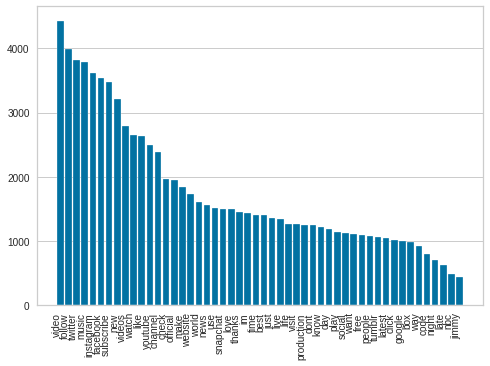

In [14]:
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.datasets import load_hobbies

# Visualizing the frequency of the top 50 words with a higher minimum and
# lower max document frequency threshold.

feature_names = vectorizer.get_feature_names()
visualizer = FreqDistVisualizer(features=feature_names, orient='v')
visualizer.fit(matrix)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


FrequencyVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fb9b2ef4150>,
                    color=None,
                    features=['available', 'beauty', 'best', 'big', 'box',
                              'business', 'buy', 'camera', 'cbs', 'channel',
                              'check', 'click', 'code', 'come', 'connect',
                              'content', 'day', 'director', 'dont', 'download',
                              'entertainment', 'episode', 'episodes',
                              'exclusive', 'facebook', 'favorite', 'film',
                              'follow', 'food', 'free', ...],
                    n=None, orient='v')

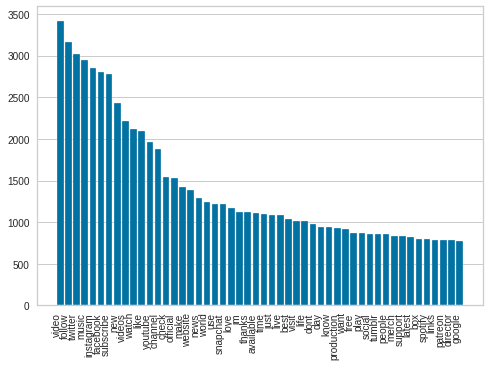

In [15]:
# Visualizing the frequency of the top 50 words with a lower minimum and
# higher max document frequency threshold.
feature_names = vectorizer_with_higher_parameters.get_feature_names()
visualizer = FreqDistVisualizer(features=feature_names, orient='v')
visualizer.fit(matrix_with_higher_parameters)

## Splitting the data


Splitting the x data with the lower max parameters 

In [16]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.25, random_state=42)


Splitting the x data with the higher max parameters 

In [17]:
from sklearn.model_selection import train_test_split

x_train_with_higher_parameters, x_test_with_higher_parameters, y_train, y_test = train_test_split(x_data_with_higher_parameters, y_data, train_size=0.25, random_state=42)


# Fully-Connected_NN

## Adding layers to the Fully-Connected Neural Network

In [18]:
import os

from sklearn.model_selection import train_test_split

from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

model = Sequential()

model.add(Dense(100, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(50,activation='relu'))
model.add(Dense(20,activation='relu'))
model.add(Dense(y_train.shape[1],activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               5100      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_3 (Dense)              (None, 15)                315       
Total params: 11,485
Trainable params: 11,485
Non-trainable params: 0
_________________________________________________________________


##Apply earlystopping

In [20]:
start_time = time.time()

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')  

checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model

model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

# metrics
print(f"Model finshed performing in {time.time() - start_time:.6f} seconds")

Epoch 1/100
320/320 - 2s - loss: 2.1604 - accuracy: 0.3122 - val_loss: 1.9032 - val_accuracy: 0.3777
Epoch 2/100
320/320 - 2s - loss: 1.8006 - accuracy: 0.4204 - val_loss: 1.7398 - val_accuracy: 0.4493
Epoch 3/100
320/320 - 2s - loss: 1.6429 - accuracy: 0.4792 - val_loss: 1.6107 - val_accuracy: 0.4917
Epoch 4/100
320/320 - 2s - loss: 1.5252 - accuracy: 0.5137 - val_loss: 1.5224 - val_accuracy: 0.5167
Epoch 5/100
320/320 - 2s - loss: 1.4254 - accuracy: 0.5416 - val_loss: 1.4438 - val_accuracy: 0.5374
Epoch 6/100
320/320 - 1s - loss: 1.3418 - accuracy: 0.5702 - val_loss: 1.3780 - val_accuracy: 0.5639
Epoch 7/100
320/320 - 1s - loss: 1.2671 - accuracy: 0.6017 - val_loss: 1.3212 - val_accuracy: 0.5870
Epoch 8/100
320/320 - 2s - loss: 1.2022 - accuracy: 0.6206 - val_loss: 1.2675 - val_accuracy: 0.6028
Epoch 9/100
320/320 - 2s - loss: 1.1462 - accuracy: 0.6419 - val_loss: 1.2311 - val_accuracy: 0.6195
Epoch 10/100
320/320 - 1s - loss: 1.0963 - accuracy: 0.6603 - val_loss: 1.1911 - val_accura

Calculate the model score

In [21]:
score = model.evaluate(x_test, y_test, verbose=0)
score

[1.0480635166168213, 0.6967960596084595]

Calculate loss and accuracy

In [22]:
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

Test loss: 1.0480635166168213
Test accuracy: 0.6967960596084595


##confusion matrix



Accuracy: 0.6967960406355822
Averaged F1: 0.6928231416256254
              precision    recall  f1-score   support

           0     0.8374    0.6647    0.7411      2866
           1     0.7278    0.7289    0.7284      1247
           2     0.5611    0.8767    0.6843      7467
           3     0.6850    0.6219    0.6520      1759
           4     0.6282    0.5559    0.5899       617
           5     0.7781    0.7997    0.7888      3086
           6     0.8693    0.7635    0.8130      4880
           7     0.9253    0.4806    0.6326      1831
           8     0.0000    0.0000    0.0000        46
           9     0.7568    0.4525    0.5664      2413
          10     0.5060    0.6148    0.5551       688
          11     0.7806    0.4207    0.5467      1835
          12     0.0000    0.0000    0.0000        38
          13     0.7242    0.6826    0.7028      1635
          14     0.7826    0.4145    0.5419       304

    accuracy                         0.6968     30712
   macro avg     0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


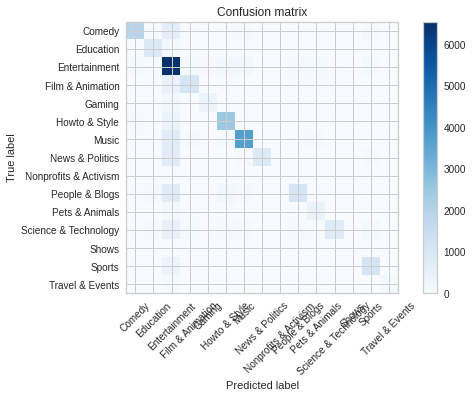

In [23]:
from sklearn import metrics

y_true = np.argmax(y_test.to_numpy(),axis=1)
pred = model.predict(x_test)
#pred = np.argmax(pred,axis=1)
pred = np.argmax(pred,axis=1)

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred, digits = 4))

from sklearn.metrics import confusion_matrix
import numpy as np
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm = confusion_matrix(y_true, pred)
plt.figure()
plot_confusion_matrix(cm, y_data.columns)
plt.show()

# Try CNN

Expanding the test and train dimensions to fit the CNN

In [24]:
x_data.shape
x_test = np.expand_dims(x_test, axis=2)
x_train = np.expand_dims(x_train, axis=2)

In [25]:
print(x_train.shape)
print(y_train.shape)

(10237, 50, 1)
(10237, 15)


## Adding layers to the Convolution Neural Network

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D
batch_size = 50
cnn = Sequential()
cnn.add(Conv1D(256, kernel_size=2, strides=2, activation='relu', input_shape=(50, 1)))

cnn.add(Conv1D(128, kernel_size=(2), strides=(2), activation='relu'))
cnn.add(MaxPooling1D(pool_size=(2)))
cnn.add(Dropout(0.5))

cnn.add(Flatten())
cnn.add(Dense(64, activation="relu"))
cnn.add(Dropout(0.5))

cnn.add(Flatten())
cnn.add(Dense(32, activation="relu"))
cnn.add(Dropout(0.5))

cnn.add(Dense(15, activation="softmax"))


In [27]:
cnn.summary()

# set the training size and testing size to limit the amount of time needed to execute
training_size = 5000
testing_size = 1000

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 25, 256)           768       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 128)           65664     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 6, 128)            0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 128)            0         
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                49216     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)               

## Train the data on the CNN model with early stopping

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

start_time = time.time()
#x_train = np.expand_dims(x_train, axis=2)
# define optimizer and objective, compile cnn

cnn.compile(loss="categorical_crossentropy", optimizer="adam", metrics = ['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto') 
#cnn.summary()
#cnn.fit(x_train[0:1000], y_train[0:1000],validation_data=(x_test[0:100],y_test[0:100]),callbacks=[monitor],verbose=2,epochs=1000)
cnn.fit(x_train, y_train,     
          epochs=10,
          verbose=2,
          validation_data=(x_test,y_test),
          callbacks=[monitor])

elapsed_time = time.time() - start_time

print("Elapsed time: {}".format(hms_string(elapsed_time)))






Epoch 1/10
320/320 - 6s - loss: 2.3715 - accuracy: 0.2412 - val_loss: 2.1483 - val_accuracy: 0.3045
Epoch 2/10
320/320 - 5s - loss: 2.2011 - accuracy: 0.2890 - val_loss: 2.0520 - val_accuracy: 0.3351
Epoch 3/10
320/320 - 5s - loss: 2.1457 - accuracy: 0.3094 - val_loss: 2.0161 - val_accuracy: 0.3484
Epoch 4/10
320/320 - 5s - loss: 2.1044 - accuracy: 0.3208 - val_loss: 1.9859 - val_accuracy: 0.3503
Epoch 5/10
320/320 - 5s - loss: 2.0638 - accuracy: 0.3306 - val_loss: 1.9367 - val_accuracy: 0.3640
Epoch 6/10
320/320 - 5s - loss: 2.0415 - accuracy: 0.3376 - val_loss: 1.9154 - val_accuracy: 0.3771
Epoch 7/10
320/320 - 5s - loss: 2.0244 - accuracy: 0.3412 - val_loss: 1.9016 - val_accuracy: 0.3861
Epoch 8/10
320/320 - 5s - loss: 1.9983 - accuracy: 0.3478 - val_loss: 1.8611 - val_accuracy: 0.3902
Epoch 9/10
320/320 - 5s - loss: 1.9830 - accuracy: 0.3510 - val_loss: 1.8481 - val_accuracy: 0.3883
Epoch 10/10
320/320 - 5s - loss: 1.9705 - accuracy: 0.3505 - val_loss: 1.8167 - val_accuracy: 0.4011

Calculate Score

In [29]:
# evaluate() computes the loss and accuracy
score = cnn.evaluate(x_test, y_test, verbose=0)
score

[1.8166680335998535, 0.40114614367485046]

Calculate loss and accuracy

In [30]:
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

Test loss: 1.8166680335998535
Test accuracy: 0.40114614367485046


## Display confusion matrix for CNN

Accuracy: 0.40114613180515757
Averaged F1: 0.3277764853674197
              precision    recall  f1-score   support

           0     0.6163    0.2275    0.3323      2866
           1     0.0000    0.0000    0.0000      1247
           2     0.3200    0.7552    0.4495      7467
           3     0.0000    0.0000    0.0000      1759
           4     0.0000    0.0000    0.0000       617
           5     0.3290    0.5373    0.4081      3086
           6     0.6284    0.6961    0.6605      4880
           7     0.5502    0.3954    0.4601      1831
           8     0.0000    0.0000    0.0000        46
           9     1.0000    0.0029    0.0058      2413
          10     0.0000    0.0000    0.0000       688
          11     0.0000    0.0000    0.0000      1835
          12     0.0000    0.0000    0.0000        38
          13     0.9240    0.1486    0.2561      1635
          14     0.0000    0.0000    0.0000       304

    accuracy                         0.4011     30712
   macro avg     0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


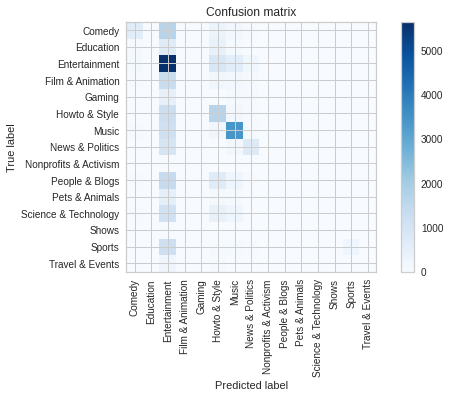

In [38]:
from sklearn import metrics

y_true = np.argmax(y_test.to_numpy(),axis=1)
pred = cnn.predict(x_test)
#pred = np.argmax(pred,axis=1)
pred = np.argmax(pred,axis=1)

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred, digits = 4))

from sklearn.metrics import confusion_matrix
import numpy as np
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm = confusion_matrix(y_true, pred)
plt.figure()
plot_confusion_matrix(cm, y_data.columns)
plt.show()


